In [13]:
import math
import random
import os
import qiskit_ionq
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFT
from getpass import getpass
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython.display import display
import time

In [2]:
def circuit_amod15(qc, qr, a, control):
    if a == 2:
        qc.cswap(control, qr[3], qr[2])
        qc.cswap(control, qr[2], qr[1])
        qc.cswap(control, qr[1], qr[0])
    elif a == 7:
        qc.cswap(control, qr[1], qr[0])
        qc.cswap(control, qr[2], qr[1])
        qc.cswap(control, qr[3], qr[2])
        for i in range(4):
            qc.cx(control, qr[i])
    elif a == 8:
        qc.cswap(control, qr[1], qr[0])
        qc.cswap(control, qr[2], qr[1])
        qc.cswap(control, qr[3], qr[2])
    elif a == 11:
        qc.cswap(control, qr[2], qr[0])
        qc.cswap(control, qr[3], qr[1])
        for i in range(4):
            qc.cx(control, qr[i])
    elif a == 13:
        qc.cswap(control, qr[3], qr[2])
        qc.cswap(control, qr[2], qr[1])
        qc.cswap(control, qr[1], qr[0])
        for i in range(4):
            qc.cx(control, qr[i])

In [3]:
def shor_period_15_ionq(a):
    counting = QuantumRegister(3, 'c')
    work = QuantumRegister(4, 'w')
    classical = ClassicalRegister(3, 'm')

    qc = QuantumCircuit(counting, work, classical)

    # |1> in work register
    qc.x(work[0])

    # Hadamards on counting register
    qc.h(counting)

    # Controlled-U^{2^k}
    for k in range(3):
        for _ in range(2**k):
            circuit_amod15(qc, work, a, counting[k])

    # Inverse QFT
    qc.append(QFT(3, inverse=True), counting)

    # Final measurement only
    qc.measure(counting, classical)

    return qc

/tmp/ipykernel_4390/3657951341.py:20: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(3, inverse=True), counting)


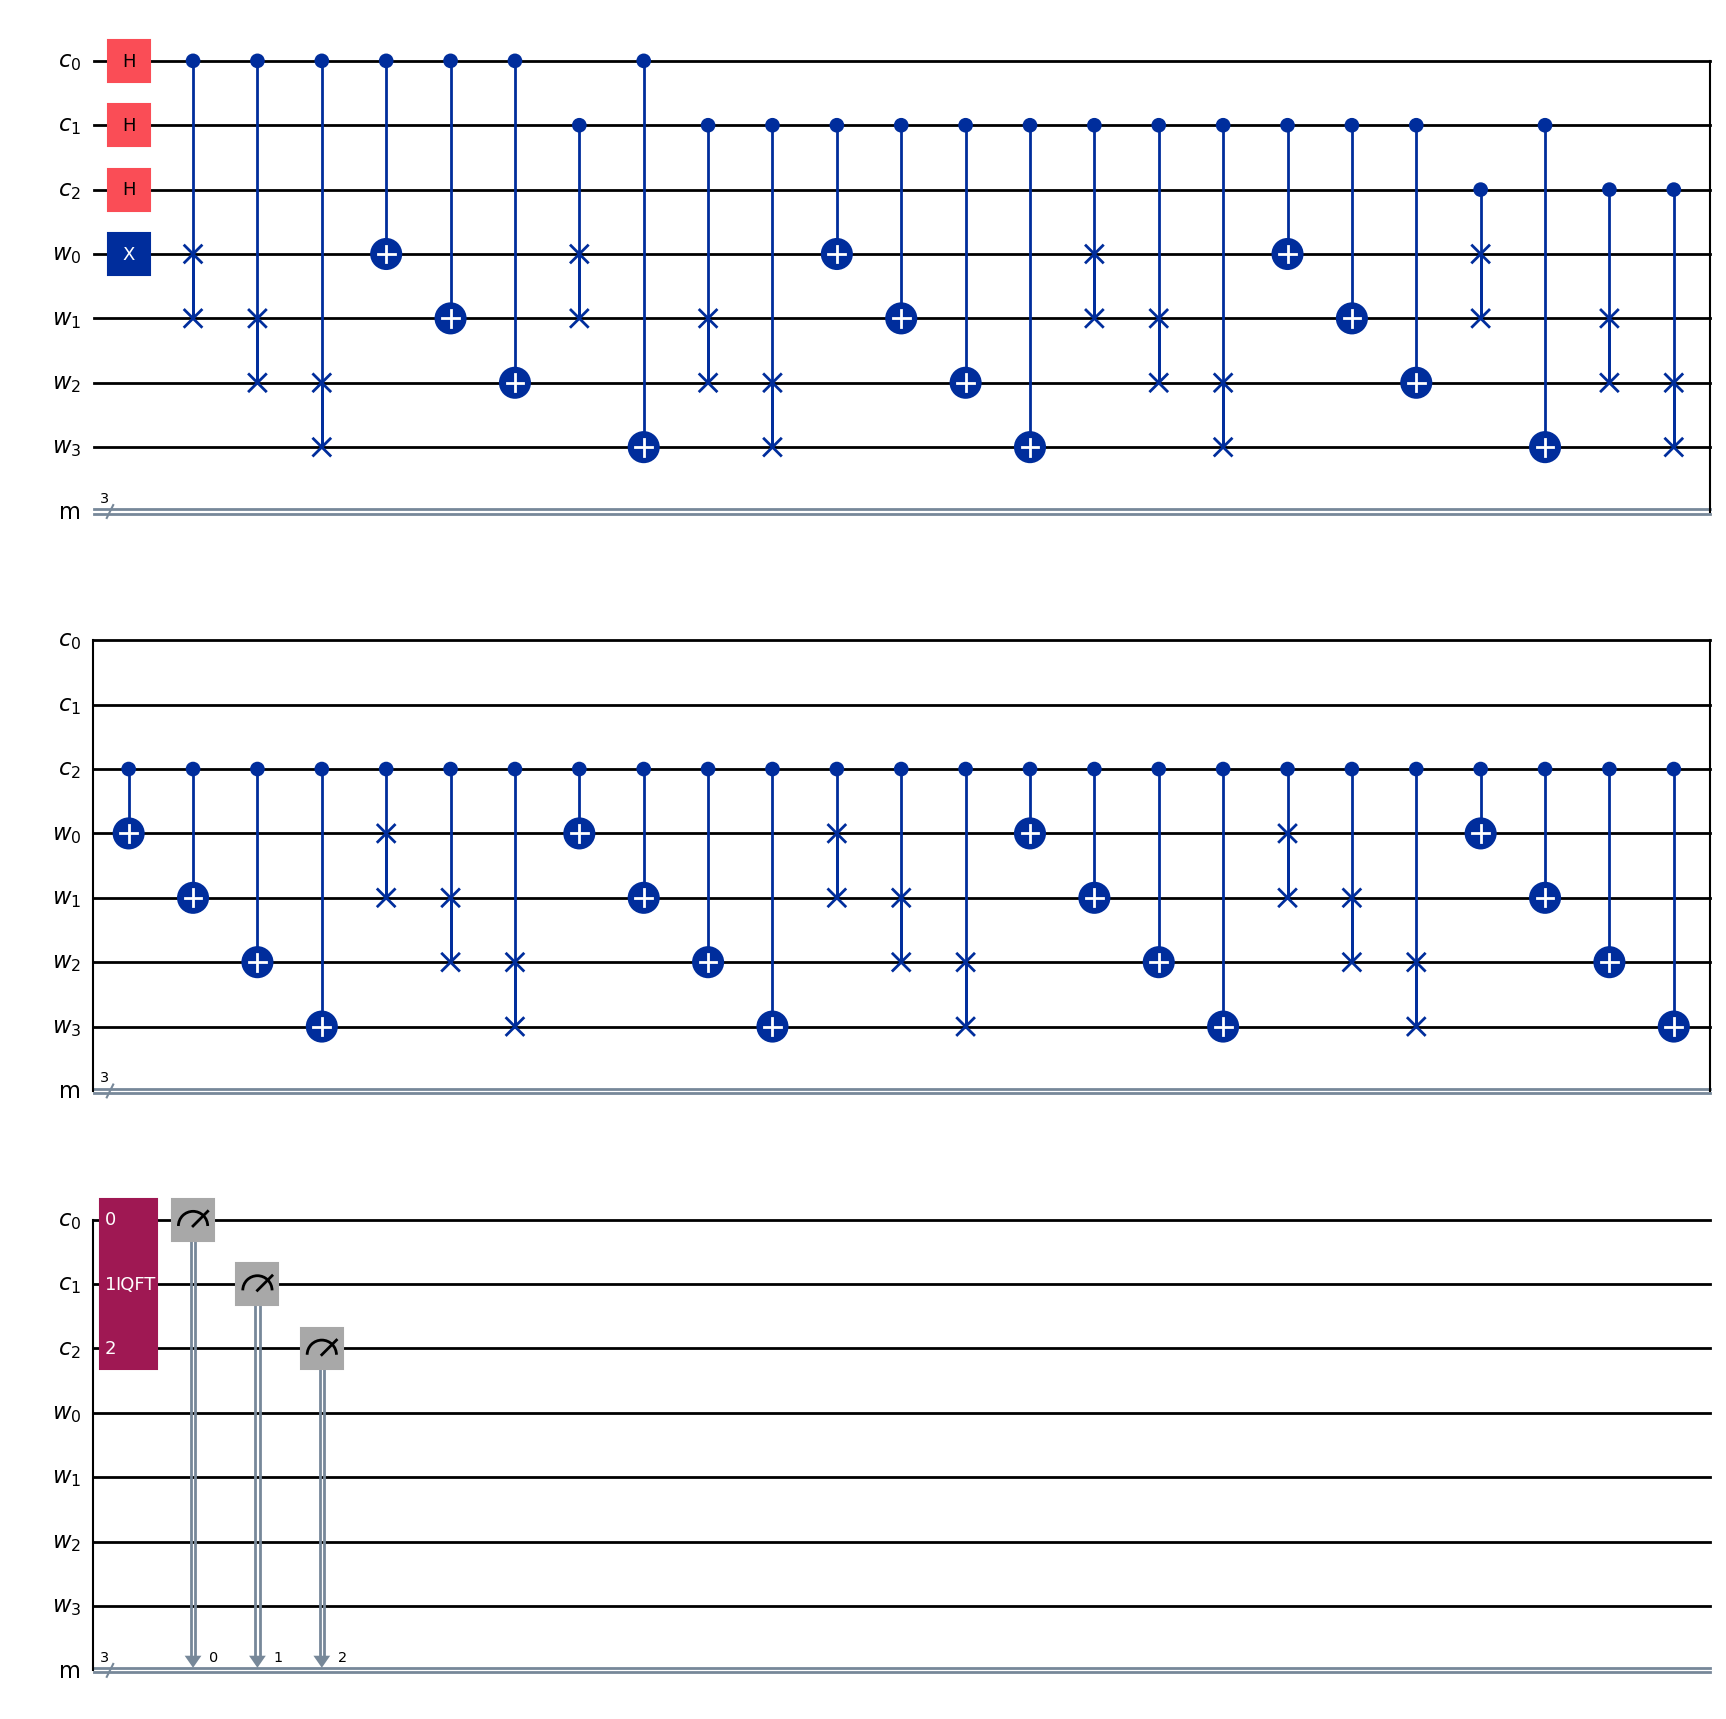

In [4]:
qc = shor_period_15_ionq(a=7)
qc.draw('mpl')

In [5]:
api_key = os.getenv('IONQ_API_KEY') or getpass("IonQ API key: ")
provider = qiskit_ionq.IonQProvider(api_key)

# Simulator (always works)
backend = provider.get_backend("ionq_simulator")

# Real hardware (choose one if you have access)
# backend = provider.get_backend("ionq_aria1")

qc_t = transpile(qc, backend, optimization_level=1)
job = backend.run(qc_t, shots=1024)
result = job.result()
counts = result.get_counts()

print(counts)

/home/killian/IonQ/qiskit_project/qiskit-env/lib/python3.12/site-packages/qiskit_ionq/ionq_backend.py:127: IonQTranspileLevelWarning: Transpiler default optimization_level=2. IonQ (QIS) recommends 0-1 to avoid aggressive re-synthesis; use transpile(..., optimization_level=1).
  warn_bad_transpile_level()


{'000': 279, '010': 232, '100': 257, '110': 256}


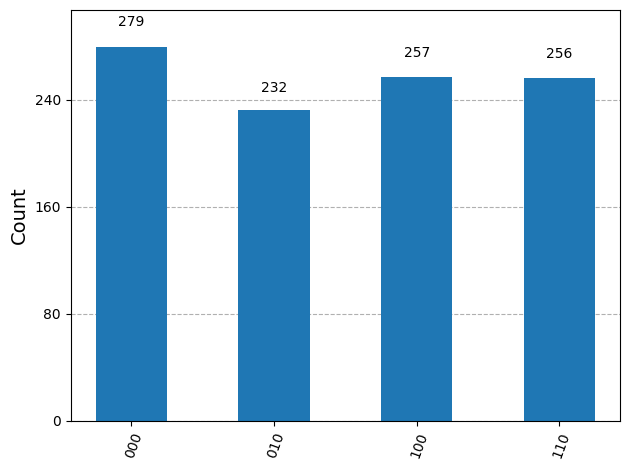

In [6]:
fig = plot_histogram(counts)
display(fig)

In [7]:
N = 15

def pick_a(N):
    while True:
        a = random.randint(2, N - 2)
        if math.gcd(a, N) == 1:
            return a

In [8]:
def find_period_quantum(a, backend, shots=1024):
    qc = shor_period_15_ionq(a)
    qc_t = transpile(qc, backend, optimization_level=1)

    job = backend.run(qc_t, shots=shots)
    result = job.result(timeout=300)
    counts = result.get_counts()

    return counts

In [9]:
from fractions import Fraction

def extract_period(counts, n_qubits):
    total = sum(counts.values())

    for bitstring, freq in sorted(counts.items(),
                                   key=lambda x: -x[1]):
        phase = int(bitstring, 2) / (2 ** n_qubits)

        frac = Fraction(phase).limit_denominator(15)
        r = frac.denominator

        if r % 2 == 0:
            return r

    return None

In [10]:
def get_factors(a, r, N):
    if r is None or r % 2 != 0:
        return None

    x = pow(a, r // 2, N)

    if x == 1 or x == N - 1:
        return None

    p = math.gcd(x - 1, N)
    q = math.gcd(x + 1, N)

    if p * q == N:
        return p, q

    return None

In [11]:
def shor_factor_15(backend):
    while True:
        a = pick_a(15)
        print(f"Chosen a = {a}")

        counts = find_period_quantum(a, backend)
        print("Measurement counts:", counts)

        r = extract_period(counts, n_qubits=3)
        print(f"Estimated period r = {r}")

        factors = get_factors(a, r, 15)
        if factors:
            return factors

In [14]:
api_key = os.getenv('IONQ_API_KEY') or getpass("IonQ API key: ")
provider = qiskit_ionq.IonQProvider(api_key)

backend = provider.get_backend("ionq_simulator")
# backend = provider.get_backend("ionq_aria1")  # real hardware

start_time = time.perf_counter()

factors = shor_factor_15(backend)

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.4f} seconds")

print("Factors of 15:", factors)

Chosen a = 7


/tmp/ipykernel_4390/3657951341.py:20: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(3, inverse=True), counting)


Measurement counts: {'000': 266, '010': 240, '100': 285, '110': 233}
Estimated period r = 2
Chosen a = 7
Measurement counts: {'000': 260, '010': 239, '100': 247, '110': 278}
Estimated period r = 4
Time taken: 11.9980 seconds
Factors of 15: (3, 5)
